# JuzData - ODSLA - Distribución de causas por Comunas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('penal_df.xlsx')

In [3]:
df.head()

,org_idradactual,exp_cuij,org_idintpri,org_cod_pri,org_descorta_pri,org_descr_Pri,org_idintseg,est_id,est_descr,exp_anio,...,den_v_domestica,den_v_genero,den_zon_id,den_zona,filter_.,org_destino_act,PrimarioDen_id,PrimarioDen_id_oju,PrimarioExp_id,PrimarioExp_oju
0,72,01-00042685-3,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,1,ASIGNADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
1,72,01-00039012-3,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
2,72,01-00035028-8,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,1,ASIGNADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
3,72,01-00036824-1,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
4,72,01-00034124-6,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1


In [4]:
df.columns

Index(['org_idradactual', 'exp_cuij', 'org_idintpri', 'org_cod_pri',
       'org_descorta_pri', 'org_descr_Pri', 'org_idintseg', 'est_id',
       'est_descr', 'exp_anio', 'exp_cuerpos', 'exp_fojas', 'exp_detenidos',
       'exp_id', 'exp_sufijo', 'exp_fechecho', 'exp_fecinidem', 'exp_fecini',
       'exp_fecreg', 'exp_fecsor', 'exp_fecelev', 'exp_letra', 'oju_id',
       'oju_descr', 'exp_ultmov', 'exp_ultmovf', 'den_id', 'den_cod_casoMPF',
       'Tipo_ingreso_MPF', 'org_cod', 'org_descr', 'org_descorta', 'org_den',
       'org_descorta_Den', 'org_descr_Den', 'den_flagrante', 'Comuna',
       'den_barrio', 'den_calle_id', 'den_cod_postal', 'den_fec_hecho',
       'den_fec_ingreso_MPF', 'den_fec_ini_comi', 'den_hora_hecho',
       'den_latitud', 'den_longitud', 'den_tipo_den', 'den_loc_id',
       'den_sin_lugar_hecho', 'den_v_domestica', 'den_v_genero', 'den_zon_id',
       'den_zona', 'filter_.', 'org_destino_act', 'PrimarioDen_id',
       'PrimarioDen_id_oju', 'PrimarioExp_id', 'Pri

In [5]:
# convierto 'unknown' en NaN para contabilizar
import itertools as it
for i, col in it.product(df.index,df.columns):
    if df.at[i,col] == 'unknown':
        df.at[i,col] = np.nan

### Polígonos

In [6]:
# Mapa de barrios de BA Data, lo llevo a geodf
import geopandas as gpd
map_df = gpd.read_file('barrios.csv')
map_df.head()

,WKT,barrio,comuna,perimetro,area,geometry
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15,7724.85295457,3115707.10627,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15,7087.51329533,2229829.03363,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15,8131.85707532,3615977.55634,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11,7705.38979708,3399595.64148,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5,8537.90136849,4050752.24524,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


In [7]:
# Polígono de CABA
from shapely.ops import unary_union
polygons = [map_df.at[i,'geometry'] for i in range(map_df.shape[0])]
caba_polygon = unary_union(polygons).buffer(10**(-12)).buffer(-10**(-12))

In [8]:
# convierte un punto en polígono 
# según EDA geográfico (ver repositorio)
from shapely.geometry import Point, Polygon
def point_to_poly(lat, lon):
    poly = Polygon([(lat,lon),(lat,lon-0.01),(lat-0.01,lon-0.01),(lat-0.01,lon)])
    return poly

In [9]:
filtro = df[df.den_latitud.notna()]
df['polygon'] = np.nan
for i in filtro.index:
    lat = df.at[i,'den_latitud']
    lon = df.at[i,'den_longitud']
    polygon = point_to_poly(lat,lon)
    polygon = polygon.intersection(caba_polygon)
    df.at[i,'polygon'] = polygon
    
df[df.polygon.notna()][['exp_cuij','den_latitud',\
        'den_longitud','Comuna','polygon']].head()

,exp_cuij,den_latitud,den_longitud,Comuna,polygon
120,01-00017018-2,-58.48,-34.62,11,"POLYGON ((-58.48 -34.62, -58.48 -34.63, -58.48..."
175,01-00015486-1,-58.51,-34.67,9,()
188,01-00017796-9,-58.44,-34.67,8,"POLYGON ((-58.44 -34.67, -58.44 -34.6798417365..."
189,01-00017796-9,-58.44,-34.67,8,"POLYGON ((-58.44 -34.67, -58.44 -34.6798417365..."
191,01-00017691-1,-58.36,-34.63,4,"POLYGON ((-58.36 -34.63, -58.36 -34.6391905815..."


In [10]:
# Chequeo los que tengan intersección nula
# (coordenadas que no pertenecen a CABA)
cuenta = 0
for i in filtro.index:
    if df.at[i,'polygon'].is_empty:
        cuenta += 1
        df.at[i,'polygon'] = np.nan
        df.at[i,'den_latitud'] = np.nan
        df.at[i,'den_longitud'] = np.nan
print(f'Se corrigieron {cuenta} instancias con error.')

Se corrigieron 1019 instancias con error.


In [11]:
# Check
nan_coords = df.den_latitud.isna().sum()
nan_polygon = df.polygon.isna().sum()
print(f'NaN coords: {nan_coords}')
print(f'NaN polygon: {nan_polygon}')

NaN coords: 27036
NaN polygon: 27036


### Comunas

In [12]:
# Creamos polígonos de las Comunas 
# con la función unary union de Shapely
comunas = map_df.comuna.unique()
comunas_geometry = []
for comuna in comunas:
    barrios = [map_df.at[i,'geometry'] for i in range(map_df.shape[0]) if map_df.at[i,'comuna'] == comuna]
    geometry = unary_union(barrios)
    comunas_geometry.append(geometry)

comunas_df = gpd.GeoDataFrame()
comunas_df['Comuna'] = comunas
comunas_df['geometry'] = comunas_geometry
# Corrijo geometría
comunas_df['geometry'] = comunas_df['geometry'].map(lambda x:x.buffer(10**(-12)).buffer(-10**(-12)))
comunas_df['Comuna'] = comunas_df['Comuna'].apply(pd.to_numeric)
comunas_df = comunas_df.sort_values(by='Comuna')
comunas_df.head()

,Comuna,geometry
6,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6..."
14,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5..."
7,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6..."
8,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6..."
2,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6..."


Para establecer la cantidad de causas por Comuna, en primer lugar tomamos en cuenta las columnas que tienen el dato en df\['Comuna'\]. De las que tengamos el datos lat/lon y no la Comuna, vamos a asignarles un valor ponderado según el área de solapamiento con los cuadrados geográficos en los que tenemos el dato de causas. Esto supone una distribución uniforme dentro de cada cuadrado, pero naturalmente está sujeto a error (mientras mayor sea el ratio perímetro / área de una Comuna, mayor será el error cometido).

In [13]:
df[df['Comuna'].notna()].shape[0]

16657

In [14]:
print(f'Total casos: {df.shape[0]}')
casos_Comu = df[df['Comuna'].notna()].shape[0]
print(f'Total datos Comuna: {casos_Comu}')
coord_sin_Comu = df[df['Comuna'].isna() & df.den_latitud.notna()].shape[0]
print(f'Total coordenadas sin Comuna: {coord_sin_Comu}')
suma_total = casos_Comu + coord_sin_Comu
print(f'Suma total: {suma_total}')
porc = round(suma_total / df.shape[0],3)*100
print(f'Porcentaje: {porc}%')

Total casos: 37136
Total datos Comuna: 16657
Total coordenadas sin Comuna: 8663
Suma total: 25320
Porcentaje: 68.2%


In [15]:
# Función de intersección: la voy a usar para
# ver si un polígono está incluido en una Comuna
def area_intersection(contained,container):
    intersec = contained.intersection(container).area
    overlap = intersec / contained.area
    return overlap

In [16]:
# Empiezo por asignar las Coordenadas sin Comunas
filtro = df[df['Comuna'].isna() & df.den_latitud.notna()]
filtro.shape[0]

8663

In [17]:
# columna con lista de overlaps 
# entre cada cuadrícula y cada Comuna
df['Comu_overlap'] = np.nan
df['Comu_overlap'] = df['Comu_overlap'].astype('object')
for i in filtro.index:
    polygon = df.at[i,'polygon']
    overlap_list = []
    for j in comunas_df.index:
        comuna_poly = comunas_df.at[j,'geometry']
        comuna = comunas_df.at[j,'Comuna']
        overlap = area_intersection(polygon,comuna_poly)
        overlap_list.append((comuna,overlap))
    df.at[i,'Comu_overlap'] = overlap_list

Cada celda de 'Comu_overlap' tiene una lista con quince tuples, donde el primer elemento es la Comuna y el segundo el overlap.

Ahora quiero ver cuando puedo asignar a una cuadrícula una Comuna directamente. La idea sería que el overlap sea uno, el problema es que por cuestiones de geometría / redondeo nunca es exactamente uno. Quiero ver si encuentro un threshold que sea un buen valor de referencia para este "overlap 100%". Para eso trabajo con un geodataframe agrupado por polígono.

In [18]:
# el código es un poquito enrevesado porque geopandas
# no me toma el polygon directamente, lo tengo que pasar a string
# y despues volver a polygon con wkt.loads

from shapely import wkt

gdf_aux = pd.DataFrame(filtro)
for i in gdf_aux.index:
    gdf_aux.at[i,'polygon'] = str(gdf_aux.at[i,'polygon'])
casos_geometry = gdf_aux['polygon'].value_counts()
casos_geometry = casos_geometry.to_frame().reset_index(drop=False)
casos_geometry = casos_geometry.rename(columns={'index':'polygon','polygon':'causas'})
casos_geo_df = gpd.GeoDataFrame(casos_geometry['causas'], 
                                geometry=casos_geometry['polygon'].apply(wkt.loads))
casos_geo_df.head()

,causas,geometry
0,165,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6..."
1,160,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6..."
2,137,"POLYGON ((-58.40000 -34.65000, -58.40000 -34.6..."
3,134,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6..."
4,134,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6..."


In [19]:
# a cada polígono le calculo su overlap con las Comunas
for i in casos_geo_df.index:
    polygon = casos_geo_df.at[i,'geometry']
    for j in comunas_df.index:
        comuna = comunas_df.at[j,'Comuna']
        comu_poly = comunas_df.at[j,'geometry']
        intersec = area_intersection(polygon,comu_poly)
        casos_geo_df.at[i,comuna] = intersec

In [20]:
casos_geo_df.head()

,causas,geometry,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,165,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6...",0.229611,0.0,0.770389,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,160,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6...",1.000000,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137,"POLYGON ((-58.40000 -34.65000, -58.40000 -34.6...",0.000000,0.0,0.000000,1.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6...",0.000000,0.0,0.315500,0.0,0.6845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,134,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6...",0.171877,0.0,0.828123,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# check que sumen todos uno
error_list = []
for i in casos_geo_df.index:
    comu_col = casos_geo_df.iloc[i,2:17]
    suma = np.sum(comu_col)
    if abs(suma - 1) > 0.0001:
        error_list.append(i)
else:
    print('Check OK')

Check OK


In [22]:
# columna con solapamiento más grande
for i in casos_geo_df.index:
    comu_col = casos_geo_df.iloc[i,2:17]
    comu_max_over = np.max(comu_col)
    casos_geo_df.at[i,'max_overlap'] = comu_max_over 

In [23]:
thresholds = [0.9,0.95,0.98,0.99,0.999,0.9999,0.99999,0.999999]
cantidades = []
for i in range(len(thresholds)):
    filtro_th = casos_geo_df['max_overlap'] > thresholds[i]
    cantidad = casos_geo_df[filtro_th].shape[0]
    cantidades.append(cantidad)

print('{:20}{:20}{:20}'.format('Threshold','Cantidad','Diferencia'))
for i in range(len(cantidades)):
    th = thresholds[i]
    cant = cantidades[i]
    dif = cantidades[i] - cantidades[i-1] 
    print('{:<20}{:<20}{:<20}'.format(th,cant,dif))

Threshold           Cantidad            Diferencia          
0.9                 144                 44                  
0.95                130                 -14                 
0.98                119                 -11                 
0.99                114                 -5                  
0.999               106                 -8                  
0.9999              103                 -3                  
0.99999             100                 -3                  
0.999999            100                 0                   


OK, empecemos por un enfoque conservador y elijamos 0.99999 como threshold.

In [24]:
# agrego Comunas a instancias que tienen lat-lon
# con polígonos 99,999% solapados con la Comuna 
filtro = df[df['Comuna'].isna() & df.den_latitud.notna()]
df['Comuna_fillna'] = 0
instancias = filtro.shape[0]
for i in filtro.index:
    overlaps = df.at[i,'Comu_overlap']
    for j in range(15):
        if overlaps[j][1] > 0.99999:
            df.at[i,'Comuna'] = overlaps[j][0]
            df.at[i,'Comuna_fillna'] = 1
            break

In [25]:
# vamos a agregar esta info a comunas_df
comunas_filldf = df[df['Comuna_fillna'] == 1]
comunas_fill_values = comunas_filldf['Comuna'].value_counts()
comunas_fill_values = comunas_fill_values.to_frame().reset_index(drop=False)
comunas_fill_values.head()

,index,Comuna
0,4,729
1,1,498
2,8,465
3,9,355
4,12,283


In [26]:
# pongo este dato en comunas_df
comunas_fill_values = comunas_fill_values.rename(columns={'index':'Comuna','Comuna':'causas_th'})

comunas_df = pd.merge(comunas_df,
                      comunas_fill_values,
                      on='Comuna',
                      how='left')
comunas_df.head()

,Comuna,geometry,causas_th
0,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",498.0
1,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...",NaN
2,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",243.0
3,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",729.0
4,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",96.0


In [27]:
comunas_df['causas_th'].fillna(0,inplace=True)

In [28]:
# check
Comunas_fill1 = df['Comuna_fillna'].sum()
Comunas_fill2 = comunas_df['causas_th'].sum()
print(f'Comunas fill en df original: {Comunas_fill1}')
print(f'Comunas fill en df Comunas: {Comunas_fill2}')

Comunas fill en df original: 3497
Comunas fill en df Comunas: 3497.0


In [29]:
# ahora los datos proporcionados
df_aux = casos_geo_df[casos_geo_df['max_overlap'] < 0.99999]
totales_th = []
for i in comunas_df.index:
    comuna = comunas_df.at[i,'Comuna']
    lista_suma = []
    for j in df_aux.index:
        causas = df_aux.at[j,'causas']
        coef = df_aux.at[j,comuna]
        # las Comunas empiezan en la col2 de casos_geo_df
        lista_suma.append(causas*coef)
    comunas_df.at[i,'causas_prop'] = np.sum(lista_suma)

comunas_df.head()

,Comuna,geometry,causas_th,causas_prop
0,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",498.0,263.789484
1,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...",0.0,197.423567
2,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",243.0,538.740335
3,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",729.0,369.276590
4,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",96.0,503.613618


In [30]:
# Check
fillna_df = df[df.Comuna.isna() & df.den_latitud.notna()].shape[0]
comu_fill_prop = comunas_df.causas_prop.sum()
print(f'Total fill proporcional: {fillna_df}')
print(f'Total en comunas_df: {comu_fill_prop}')

Total fill proporcional: 5166
Total en comunas_df: 5166.000001189085


Ahora los casos que tienen las Comunas en el df original (es decir, excluyo los que rellené, indicados en la columna 'Comuna_fillna').

In [31]:
df_Comu = df[df['Comuna'].notna() & \
            df['Comuna_fillna'] == 0]
comunas_notna = df_Comu['Comuna'].value_counts()

comunas_notna = comunas_notna.to_frame().reset_index(drop=False)
comunas_notna = comunas_notna.rename(columns={'index':'Comuna','Comuna':'causas_notna'})
comunas_notna.head()

,Comuna,causas_notna
0,1,2938
1,7,1777
2,4,1755
3,3,1478
4,8,1137


In [32]:
comunas_df = pd.merge(comunas_df,
                      comunas_notna,
                      on='Comuna',
                      how='left')
comunas_df.head()

,Comuna,geometry,causas_th,causas_prop,causas_notna
0,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",498.0,263.789484,2938
1,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...",0.0,197.423567,616
2,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",243.0,538.740335,1478
3,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",729.0,369.276590,1755
4,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",96.0,503.613618,705


In [33]:
comunas_df['causas_tot'] = comunas_df['causas_th'] + comunas_df['causas_prop'] + comunas_df['causas_notna']
comunas_df.head()

,Comuna,geometry,causas_th,causas_prop,causas_notna,causas_tot
0,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",498.0,263.789484,2938,3699.789484
1,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...",0.0,197.423567,616,813.423567
2,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",243.0,538.740335,1478,2259.740335
3,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",729.0,369.276590,1755,2853.276590
4,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",96.0,503.613618,705,1304.613618


In [34]:
# Check
casos_Comu = df[(df['Comuna'].notna()) & \
                (df['Comuna_fillna'] == 0)].shape[0]
print(f'Casos notna df original: {casos_Comu}')
print('Casos notna df procesado: '+str(comunas_df['causas_notna'].sum()))

coord_sin_Comu = df[(df['Comuna'].isna()) & \
                    (df['den_latitud']) | \
                    (df['Comuna_fillna'] == 1)].shape[0]

print(f'Casos isna df original: {coord_sin_Comu}')

causas_th = comunas_df['causas_th'].sum()
causas_prop = comunas_df['causas_prop'].sum()
print('Casos isna df procesado: '+str(causas_th+causas_prop))

Casos notna df original: 16657
Casos notna df procesado: 16657
Casos isna df original: 8663
Casos isna df procesado: 8663.000001189084


In [35]:
# Agrego una coordenada de cada polígono al geoDataFrame
# esto es para los labels del mapa
comunas_df['coords'] = comunas_df['geometry'].apply(lambda x: x.representative_point().coords[:])
comunas_df['coords'] = [coords[0] for coords in comunas_df['coords']]
comunas_df.head()

,Comuna,geometry,causas_th,causas_prop,causas_notna,causas_tot,coords
0,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",498.0,263.789484,2938,3699.789484,"(-58.37920119008943, -34.605895270000005)"
1,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...",0.0,197.423567,616,813.423567,"(-58.393353948859556, -34.584020127849996)"
2,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",243.0,538.740335,1478,2259.740335,"(-58.40227541693436, -34.614390757500004)"
3,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",729.0,369.276590,1755,2853.276590,"(-58.39171430943253, -34.6399410959)"
4,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",96.0,503.613618,705,1304.613618,"(-58.420549629235715, -34.618844705149996)"


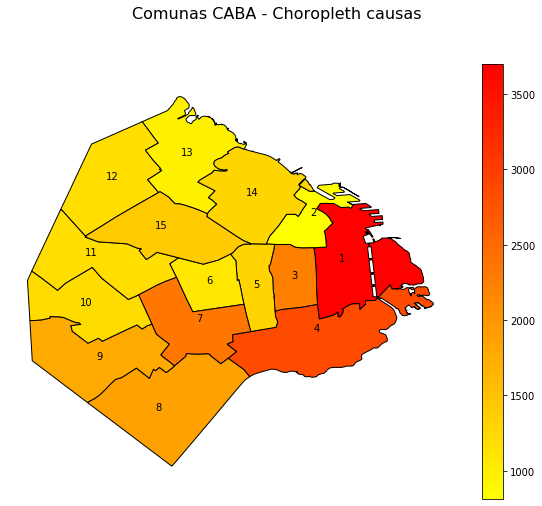

In [36]:
fig, ax = plt.subplots(1, figsize=(10, 8))
comunas_df.plot(ax=ax,edgecolor='0',column='causas_tot',
                legend=True,cmap='autumn_r')
# Labeleo el nombre a cada comuna
for idx, row in comunas_df.iterrows():
    plt.annotate(s=row['Comuna'], xy=row['coords'],
                 horizontalalignment='center')
ax.axis('off')
fig.suptitle('Comunas CABA - Choropleth causas',fontsize=16)
plt.show()

In [37]:
comunas_df.drop(columns='coords',inplace=True)

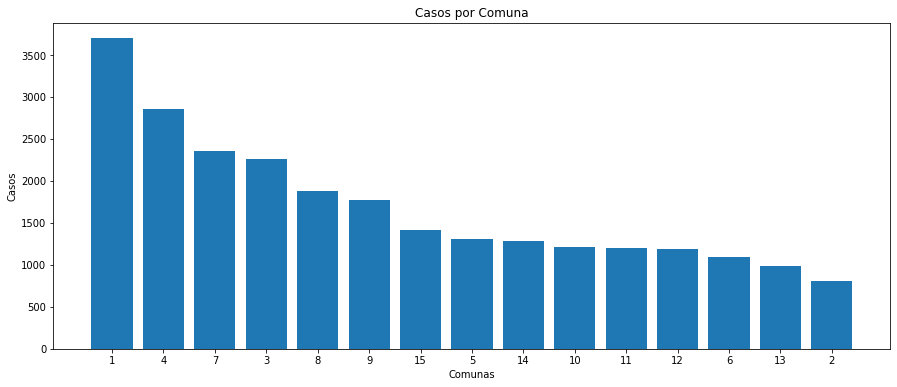

In [38]:
# Ploteamos casos por Comuna
plt.figure(figsize=(15,6))
comunas_sort = comunas_df.sort_values(by='causas_tot',
                                      ascending=False)
plt.bar(x=comunas_sort['Comuna'].astype('str'),
        height=comunas_sort['causas_tot'])
plt.xlabel('Comunas')
plt.ylabel('Casos')
plt.title('Casos por Comuna')
plt.show()

In [39]:
df.to_excel('penaldf_geo.xlsx')

In [40]:
comunas_df.columns

Index(['Comuna', 'geometry', 'causas_th', 'causas_prop', 'causas_notna',
       'causas_tot'],
      dtype='object')

In [41]:
comunas_export = comunas_df[['Comuna','geometry']]
comunas_export.to_file('comunas_df.shp')

### Correlaciones

En este apartado estudiamos la relación entre la cantidad de causas por Comuna y algunas variables relevantes. La información proviene de la [Dirección General de Estadística y Censos de la Ciudad de Buenos Aires](https://www.estadisticaciudad.gob.ar/eyc/), y del [Mapa del Delito](https://mapa.seguridadciudad.gob.ar/).

In [42]:
comunas_df['area'] = comunas_df['geometry'].area*10000

In [43]:
# Poblacion por Comuna
pobl_comu = pd.read_excel('Comunas/Poblacion_DGECBA.xls')
pobl_comu.head(3)

,Comuna,2019
0,1,255457
1,2,149510
2,3,193115


In [44]:
# Ingresos promedio por Comuna
# por tipo de Ingreso
ingr_comu = pd.read_excel('Comunas/Ingresos_DGECBA.xlsx')
ingr_comu.head(3)

,Comuna,Total,Empleador,Cuenta Propia,Asalariado
0,3,31808,26582,22670,33829
1,9,29546,30327,22145,31473
2,6,43608,50164,33498,45401


In [45]:
# Porcentaje de hogares con Necesidades Básicas Insatisfechas
nbi_comu = pd.read_excel('Comunas/NBI_DGECBA2010.xls')
nbi_comu.head(3)

,Comuna,Porc NBI
0,1,7.006598
1,2,18.121465
2,3,2.425520


In [46]:
pobl_comu = pobl_comu.rename(columns={2019:'pobl'})
comunas_df = pd.merge(comunas_df,
                     pobl_comu,
                     on='Comuna')

ingr_comu = ingr_comu.rename(columns={'Total':'IngrProm'})
comunas_df = pd.merge(comunas_df,
                     ingr_comu,
                     on='Comuna')

comunas_df = pd.merge(comunas_df,
                     nbi_comu,
                     on='Comuna')

comunas_df.head()

,Comuna,geometry,causas_th,causas_prop,causas_notna,causas_tot,area,pobl,IngrProm,Empleador,Cuenta Propia,Asalariado,Porc NBI
0,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",498.0,263.789484,2938,3699.789484,17.076418,255457,38100,113348,28641,34950,7.006598
1,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...",0.0,197.423567,616,813.423567,6.206999,149510,55625,177237,48069,50132,18.121465
2,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",243.0,538.740335,1478,2259.740335,6.276610,193115,31808,26582,22670,33829,2.425520
3,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",729.0,369.276590,1755,2853.276590,21.320384,239712,26058,59375,22015,26446,12.589693
4,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",96.0,503.613618,705,1304.613618,6.546794,187348,37094,58998,29587,37910,14.913115


A continuación vamos a usar los datos del Mapa del Delito, basados en denuncias en Comisarías, con delitos que no están incluidos en la competencia de los Tribunales Penales, Contravencionales y de Faltas (Robos, Hurtos, Lesiones).

Esto me servirá para confirmar la robustez de mis conclusiones, dadas las falencias de nuestra base de datos. Si las Comunas con más causas son Comunas con más delitos, entonces me siento más confiado en sacar conclusiones con respecto a la distribución geográfica de causas.

In [47]:
mapa_delito = pd.read_csv('MapaDelDelito/delitos_2019.csv')

In [48]:
mapa_delito.head()

,id,fecha,franja_horaria,tipo_delito,subtipo_delito,cantidad_registrada,comuna,barrio,lat,long
0,374556,2019-01-01,12,Lesiones,Siniestro Vial,1.0,4.0,Nueva Pompeya,-34.648387,-58.404748
1,426152,2019-01-01,6,Robo (con violencia),NaN,1.0,9.0,Liniers,-34.649827,-58.513859
2,371604,2019-01-01,8,Lesiones,Siniestro Vial,1.0,15.0,Chacarita,-34.588108,-58.439392
3,425359,2019-01-01,16,Hurto (sin violencia),Hurto Automotor,1.0,10.0,Floresta,-34.631877,-58.483975
4,437571,2019-01-01,2,Robo (con violencia),Robo Automotor,1.0,4.0,Parque Patricios,-34.633161,-58.397123


In [49]:
mapa_delito.shape

(117661, 10)

In [50]:
mapa_delito['comuna'].isna().sum()

597

In [51]:
# son poquitos NaNs, los vuelos
mapa_delito = mapa_delito[mapa_delito['comuna'].notna()]
# para poder mergear despues
mapa_delito['comuna'] = mapa_delito['comuna'].astype(np.int64)

In [52]:
delitos_comuna = mapa_delito['comuna'].value_counts()
delitos_comuna = delitos_comuna.to_frame().reset_index(drop=False)
delitos_comuna.head()

,index,comuna
0,1,18874
1,3,11135
2,4,9920
3,14,9559
4,7,7768


In [53]:
delitos_comuna = delitos_comuna.rename(columns={'index':'Comuna','comuna':'delitos'})

comunas_df = pd.merge(comunas_df,
                      delitos_comuna,
                      on='Comuna',
                      how='left')

comunas_df.head()

,Comuna,geometry,causas_th,causas_prop,causas_notna,causas_tot,area,pobl,IngrProm,Empleador,Cuenta Propia,Asalariado,Porc NBI,delitos
0,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",498.0,263.789484,2938,3699.789484,17.076418,255457,38100,113348,28641,34950,7.006598,18874
1,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...",0.0,197.423567,616,813.423567,6.206999,149510,55625,177237,48069,50132,18.121465,5589
2,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",243.0,538.740335,1478,2259.740335,6.276610,193115,31808,26582,22670,33829,2.425520,11135
3,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",729.0,369.276590,1755,2853.276590,21.320384,239712,26058,59375,22015,26446,12.589693,9920
4,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",96.0,503.613618,705,1304.613618,6.546794,187348,37094,58998,29587,37910,14.913115,6720


In [54]:
# variables adicionales que quiero estudiar
comunas_df['causas_capita'] = comunas_df['causas_tot'] / comunas_df['pobl']
comunas_df['causas_area'] = comunas_df['causas_tot'] / comunas_df['area']
comunas_df['pobl_area'] = comunas_df['pobl'] / comunas_df['area']

In [55]:
comunas_df.columns

Index(['Comuna', 'geometry', 'causas_th', 'causas_prop', 'causas_notna',
       'causas_tot', 'area', 'pobl', 'IngrProm', 'Empleador', 'Cuenta Propia',
       'Asalariado', 'Porc NBI', 'delitos', 'causas_capita', 'causas_area',
       'pobl_area'],
      dtype='object')

In [92]:
column_corr = ['causas_tot','area','pobl','Asalariado','Porc NBI',
               'causas_capita','causas_area','pobl_area','delitos']
comu_corr = comunas_df[column_corr].corr()

In [93]:
comu_corr[['causas_tot','causas_capita','causas_area']]

,causas_tot,causas_capita,causas_area
causas_tot,1.000000,0.946703,0.495823
area,0.422554,0.290288,-0.501425
pobl,0.626431,0.365038,0.024698
Asalariado,-0.617668,-0.699403,-0.248809
Porc NBI,0.017314,0.128199,0.010522
causas_capita,0.946703,1.000000,0.598699
causas_area,0.495823,0.598699,1.000000
pobl_area,-0.163776,-0.086980,0.713256
delitos,0.838425,0.745972,0.503205


In [94]:
comu_pearson = pd.DataFrame({'variable':['causas_tot','causas_tot','causas_capita',
                                         'causas_capita','causas_area','causas_area'],
                            'value':['corr','p-val','corr','p-val',
                                    'corr','p-val',]})
comu_pearson.head(4)

,variable,value
0,causas_tot,corr
1,causas_tot,p-val
2,causas_capita,corr
3,causas_capita,p-val


In [95]:
from scipy.stats import pearsonr

column_pearson = ['area','pobl','Asalariado',
              'Porc NBI','pobl_area','delitos']

for col in column_pearson:
    comu_pearson.at[0,col] = pearsonr(comunas_df['causas_tot'],comunas_df[col])[0]
    comu_pearson.at[1,col] = pearsonr(comunas_df['causas_tot'],comunas_df[col])[1]
    comu_pearson.at[2,col] = pearsonr(comunas_df['causas_capita'],comunas_df[col])[0]
    comu_pearson.at[3,col] = pearsonr(comunas_df['causas_capita'],comunas_df[col])[1]
    comu_pearson.at[4,col] = pearsonr(comunas_df['causas_area'],comunas_df[col])[0]
    comu_pearson.at[5,col] = pearsonr(comunas_df['causas_tot'],comunas_df[col])[1]

comu_pearson

,variable,value,area,pobl,Asalariado,Porc NBI,pobl_area,delitos
0,causas_tot,corr,0.422554,0.626431,-0.617668,0.017314,-0.163776,0.838425
1,causas_tot,p-val,0.116619,0.012465,0.014142,0.951165,0.559736,0.000094
2,causas_capita,corr,0.290288,0.365038,-0.699403,0.128199,-0.086980,0.745972
3,causas_capita,p-val,0.293919,0.180942,0.003708,0.648874,0.757905,0.001406
4,causas_area,corr,-0.501425,0.024698,-0.248809,0.010522,0.713256,0.503205
5,causas_area,p-val,0.116619,0.012465,0.014142,0.951165,0.559736,0.000094


In [71]:
comu_heat = comu_pearson[comu_pearson['value'] != 'p-val']
comu_heat = comu_heat.drop(columns='value')
comu_heat = comu_heat.set_index(keys='variable')
comu_heat

,area,pobl,Asalariado,Porc NBI,pobl_area,delitos
variable,,,,,,
causas_tot,0.422554,0.626431,-0.617668,0.017314,-0.163776,0.838425
causas_capita,0.290288,0.365038,-0.699403,0.128199,-0.086980,0.745972
causas_area,-0.501425,0.024698,-0.248809,0.010522,0.713256,0.503205


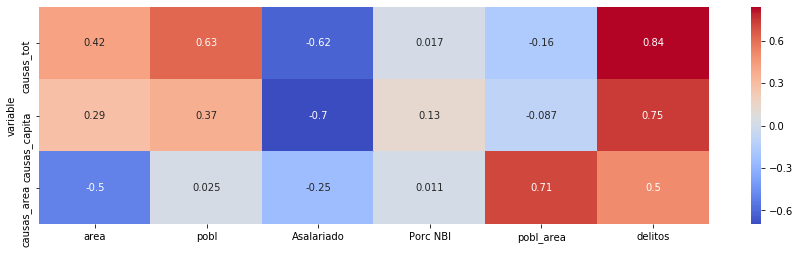

In [72]:
plt.figure(figsize=(15,4))
sns.heatmap(comu_heat,
            annot=True,
            cmap='coolwarm')
plt.show()

Correlaciones que se pueden apreciar en este heatmap:
* Las Comunas con más delitos según el Mapa del Delito tienen también más causas judiciales. Esto, como se señaló más arriba, me da mayor confianza en cuanto a la solidez de las conclusiones que siguen.
* A mayor población, mayor cantidad de causas (conclusión que coincide con el otro notebook de Análisis Geográfico).
* La densidad poblacional no afecta cantidad de casos total ni el ratio causas/habitantes.
* A menor ingreso (en particular de los empleados), más causas per cápita. 

Este último punto es especialmente relevante desde el punto de vista de la equidad en el servicio de Justicia. Las Comunas con habitantes asalariados de menores ingresos son las Comunas con más causas. No debiera ser sorprendente: la falta de ingresos es una fuente de conflictividad mayúscula, especialmente en el tipo de delitos que tramitan estos juzgados (donde por ejemplo el robo, que puede ser un delito entre personas de diferente nivel de ingresos, no está incluido).

Una consecuencia muy importante de esta relación: asignar las causas en base a Comunas traerá como consecuencia que <b>las personas con menos ingresos</b> tengan mayor probabilidad de tramitar sus causas <b>en juzgados con mayor carga de trabajo.</b> A su vez, las causas en juzgados más cargados tendrán menos recursos (tiempo, personas, atención) para tramitarse (porque todos los juzgados tienen los mismos recursos). Es decir, distribuir causas en base a Comunas (con juzgados de iguales recursos) es asignar menos recursos judiciales a personas con menos ingresos. Dicho de otro modo, bajo este esquema ser pobre implica tener un servicio de Justicia de menor calidad.

### Otras variables relevantes

En este apartado revisaremos la relacion entre la cantidad de causas y otras variables asociadas a la misma en las estadisticas criminologicas habituales. Para estas variables se cuenta con informacion por Comuna provista por la Direccion General de Estadisticas y Censos de la Ciudad de Buenos Aires. 

In [85]:
# Sexo del jefe de hogar
sexo_jefe_hogar = pd.read_excel('Comunas/SexoJefeHogar.xlsx')
sexo_jefe_hogar.head(3)

,Comuna,JH Varon,JH Mujer
0,1,61.0,39.0
1,2,47.6,52.4
2,3,47.9,52.1


In [80]:
# Situacion ocupacional del jefe de hogar
ocupacion_jefe_hogar = pd.read_excel('Comunas/OcupacionJefeHogar.xlsx')
ocupacion_jefe_hogar.head(3)

,Comuna,JH Ocupado,JH Desocupado,JH Inactivo
0,Total,70.4,4.0,25.6
1,1,75.0,6.0,19.0
2,2,68.9,3.3,27.8


In [82]:
# Edad jefe de hogar
edad_jefe_hogar = pd.read_excel('Comunas/EdadJefeHogar.xlsx')
edad_jefe_hogar.head(3)

,Comuna,Edad hasta 29,Edad 30 - 39,Edad 40 - 49,Edad 50 - 59,Edad 60 y más
0,1,13.3,20.4,19.1,17.6,29.6
1,2,21.9,16.3,14.5,14.1,33.2
2,3,15.1,17.5,19.7,13.4,34.3


In [86]:
comunas_df = pd.merge(comunas_df,sexo_jefe_hogar,on='Comuna')
comunas_df = pd.merge(comunas_df,ocupacion_jefe_hogar,on='Comuna')
comunas_df = pd.merge(comunas_df,edad_jefe_hogar,on='Comuna')

In [87]:
column_corr2 = ['causas_tot','causas_capita','causas_area',
                'JH Varon','JH Desocupado','Edad hasta 29']
comu_corr2 = comunas_df[column_corr2].corr()

In [88]:
comu_pearson2 = pd.DataFrame({'variable':['causas_tot','causas_tot','causas_capita',
                                         'causas_capita','causas_area','causas_area'],
                            'value':['corr','p-val','corr','p-val',
                                    'corr','p-val',]})

In [98]:
column_pearson2 = ['JH Varon','JH Desocupado','Edad hasta 29']

for col in column_pearson2:
    comu_pearson2.at[0,col] = pearsonr(comunas_df['causas_tot'],comunas_df[col])[0]
    comu_pearson2.at[1,col] = pearsonr(comunas_df['causas_tot'],comunas_df[col])[1]
    comu_pearson2.at[2,col] = pearsonr(comunas_df['causas_capita'],comunas_df[col])[0]
    comu_pearson2.at[3,col] = pearsonr(comunas_df['causas_capita'],comunas_df[col])[1]
    comu_pearson2.at[4,col] = pearsonr(comunas_df['causas_area'],comunas_df[col])[0]
    comu_pearson2.at[5,col] = pearsonr(comunas_df['causas_tot'],comunas_df[col])[1]

comu_pearson2

,variable,value,JH Varon,JH Desocupado,Edad hasta 29
0,causas_tot,corr,0.210569,0.356162,0.053136
1,causas_tot,p-val,0.451278,0.192585,0.850821
2,causas_capita,corr,0.182798,0.283225,0.056654
3,causas_capita,p-val,0.514347,0.306353,0.841054
4,causas_area,corr,-0.119108,-0.131178,0.348535
5,causas_area,p-val,0.451278,0.192585,0.850821


In [99]:
comu_heat2 = comu_pearson2[comu_pearson['value'] != 'p-val']
comu_heat2 = comu_heat2.drop(columns='value')
comu_heat2 = comu_heat2.set_index(keys='variable')
comu_heat2

,JH Varon,JH Desocupado,Edad hasta 29
variable,,,
causas_tot,0.210569,0.356162,0.053136
causas_capita,0.182798,0.283225,0.056654
causas_area,-0.119108,-0.131178,0.348535


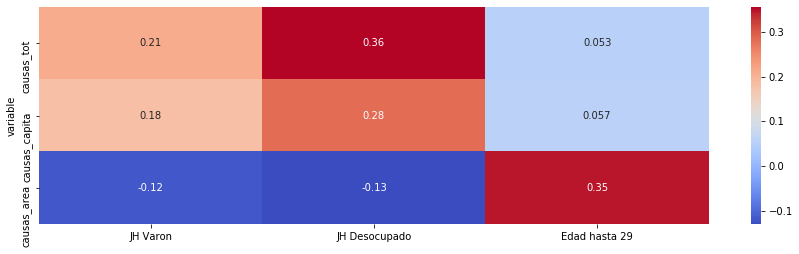

In [100]:
plt.figure(figsize=(15,4))
sns.heatmap(comu_heat2,
            annot=True,
            cmap='coolwarm')
plt.show()

Variables con correlacion positiva interesante: porcentaje de Jefes de Hogar desocupados con la cantidad de causas per capita y la cantidad de causas totales. Porcentajes de jefe de hogar jovenes con causas por area. 

<b>De todos modos ningun p-value es significativo.</b>